<a href="https://colab.research.google.com/github/nebuchadnezzarr/Object-Detection/blob/master/socket_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Установка параметров выбранной модели нейронной сети

Весь список моделей можно найти по первой ссылке, по второй - все параметры и характеристики.
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models 
https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs

In [0]:
repo_url = 'https://github.com/nebuchadnezzarr/dataset'  # ссылка на мой датасет, хранящийся на гитхабе 

# Количество тренировочных шагов
num_steps = 1000  # 200000

# Количество эпох
num_eval_steps = 50

#Параметры преобученной модели
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {  #Название выбранной модели
        
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29', 
        'pipeline_file': 'ssd_mobilenet_v2_coco.config', #Название файла конфигурации, в нем указываются все параметры данных, набор метрик, выбор набора данных для обучения, тренировки и тд.
        'batch_size': 12 # Число картинок в одном баче 
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}


selected_model = 'ssd_mobilenet_v2' 

#Имя модели, используемой для детекции 
MODEL = MODELS_CONFIG[selected_model]['model_name']

#Имя файла конфигурации 
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
# Размер тренировочной партии вписывается в память графического процессора Tesla K80 Colabe для выбранной модели
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Загрузка репозитория с датасетом

In [0]:
 import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'dataset'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 353 (delta 8), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (353/353), 30.12 MiB | 11.00 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/content/dataset
Already up to date.


In [0]:
%cd data/ 

/content/dataset/data


In [0]:
!ls images


test  train


## Установка TensorFlow Detection API и необходимых пакетов

In [0]:

import numpy as np
import os                                                    
import itertools
from IPython.display import SVG
import cv2
import matplotlib.pyplot as plt                             
from PIL import Image
import pylab
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from cv2 import imshow
from google.colab.patches import cv2_imshow
import random
from random import randint





%cd /content
!git clone --quiet https://github.com/tensorflow/models.git    #Установка с репозитория моделей для tf detection api

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk  #Для работы с файлами xml и csv

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/' #Делаем все наши изменения постоянными

!python object_detection/builders/model_builder_test.py  #Запускаем тест 

/content
Selecting previously unselected package python-bs4.
(Reading database ... 130911 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## Подготовка tfrecors файлов

Tfrerocrd файлы необходимы нам для хранения предварительно обработанной версии набора данныъ - тк данных много, данные сжимаются и хранятся как tfrecords в файлах  label_map, train.record, test.record

Два файла train.record и test.record, оба представляют собой бинарные файлы, каждый из которых содержит закодированный jpg и информацию о разметке каждого объекта на изображении для соответствующего набора train / test. Формат файла tfrecord проще в использовании и быстрее загружается на этапе обучения по сравнению с хранением каждого изображения и разметки отдельно.
Файл label_map  отображает каждое имя класса объекта в виде целого числа. Может использоваться для детекции нескольких классов на изображении.


In [0]:
%cd {repo_dir_path}


!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations #конвертируем xml файлы из папки train в таблицу csv


!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv #конвертируем xml файлы из папки test в таблицу csv 

# Создаем tfrecord файлы

!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Создаем tfrecord файлы

!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/dataset
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Successfully created the TFRecords: /content/dataset/data/annotations/train.record
Successfully created the TFRecords: /content/dataset/data/annotations/test.record


In [0]:
test_record_fname = '/content/dataset/data/annotations/test.record'    
train_record_fname = '/content/dataset/data/annotations/train.record'
label_map_pbtxt_fname = '/content/dataset/data/annotations/label_map.pbtxt'

## Скачиваем предварительно обученную модель

как я понял, предварительно обученная модель на многих образцах - гораздо лучше подходит для детекции, я разные картинки пробовал - все детектило на ура,
тк обучение проходит не с нуля, а с некой отправной точки "чекпоинта" - когда нейронная сеть уже имеет "опыт" и какие-то заданные параметры. Для улучшения качества детекции необходим больший датасет.
Для обучения мы сначала загрузим предварительно обученные весовые коэффициенты / контрольные точки модели, а затем настроим соответствующий файл конфигурации, чтобы сообщить модели следующую информацию: 

Путь к предварительно обученной модели и ее контрольной точке (fine_tune_checkpoint), путь к файлам tfrecord, label_map, количество тренировочных эпох (шагов) (num_steps), количество классов для каждого уникального объекта (num_classes)

In [0]:


%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 71 root   root  4.0K May 30 21:56 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Параметры файла конфигурации

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)  

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):       #Данные параметры скачены из файла конфигов для нейронок (ссылка в начале ноутбука), как я понял, максимум эта модель может 90 классов детектить 
    from object_detection.utils import label_map_util #данная функция возвращает номер каждого класса объекта (удобно если классов несколько)
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname) #количество классов объекта
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f: #считывание файла конфигурации
    
    # Та самая отправня точка обучения, чекпоинт, чтобы обучение не начиналось с нуля
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # Считывание tfrecord файлов из test и train наборов
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # считывание label_map - файла, куда записаны tfrecord-ы
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Размер бача был задан в самом начале, я так понимаю, здесь можно дополнительно провести настройку
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Аналогично с шашами и количеством классов, тк пока что я использовал только один класс, здесь же регулируется вывод числа классов в целом
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

##Архитектура сети 
Используется сеть SSD Mobilent v2


In [0]:
!cat {pipeline_fname}   #Архитектура и конфигурация использованной сети.

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [0]:
model_dir = 'training/'     
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

##TensorBoard визуализация работоспособности модели
Для оценки результатов обучения и детекции на тестовой выборке используется tensorboard, с графиками потерь loss, скоростью обучения, точностью.

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-05-30 21:56:37--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.136.9, 34.195.49.195, 34.206.36.121, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.136.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  8.67MB/s    in 1.8s    

2019-05-30 21:56:40 (8.67 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


## Тренировка модели по заданным параметрам

Начало обучения, pipeline_fame - путь к файлу конфигурации,  model_dir - это путь к новому каталогу для хранения нашей выходной модели, num_steps и num_eval_steps  количество эпох (шагов) обучения и оценка

In [0]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-05-30 21:57:10.969193: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-05-30 21:57:10.969513: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x139b9600 executing computations on platform Host. Devices:
2019-05-30

In [0]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1559253428.e7fd9bdd6217
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta


## Скачивание обученной модели на наших параметрах

Скачивание модели обнаружения объектов по использованным данным,  то есть frozen_inference_graph.pb загруженный из Colab после обучения.
Измененный файл конфигураций pipeline config, использовавшийся для обучения. Также скачивается с Colab после обучения.


In [0]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

training/model.ckpt-1000
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
146 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by 

In [0]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M May 30 22:10 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


##Сохранение модели и скачивание с помощью Pydrive на гугл диск

In [0]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)

uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

     |████████████████████████████████| 993kB 39.6MB/s 
Uploaded file with ID 1smfLAVJkB2PsbMWwwt1isaA_3nmo_279


## TensorBoard для оценки работоспособности модели
Перейдя по ссылке и во вкладке Scalar выбрав eval_0 и result (синий и оранжевый круги), получаем следующие графики:
loss_1 и loss_2 показывают значения потерь (ошибок), а также 
learning_rate_1 скорость обученияи и прочие.

Во вкладке Images - визуальное сравнение детекции по тестовой выборке с разметкой изображения из тренировочной выборки


In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://fa304e28.ngrok.io


###Загрузка тестовой выборки

In [0]:
import os
import glob

# Путь к модели, которая будет использована для обнаружения
PATH_TO_CKPT = pb_fname

# Список строк, который используется для добавления правильной метки для каждого поля.
PATH_TO_LABELS = label_map_pbtxt_fname

PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test") #путь к папке с тестовой выборкой

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*")) 
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR) #считывание тестовых изображений
print(TEST_IMAGE_PATHS)

['/content/dataset/test/1.JPG']


/content/models/research/object_detection


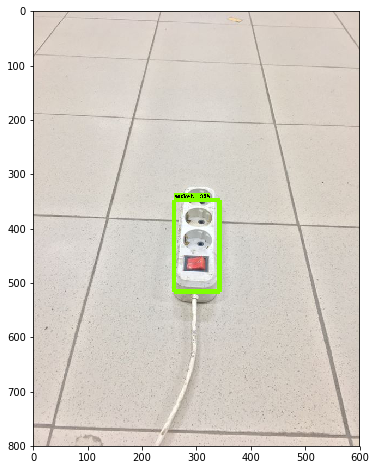

In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image


sys.path.append("..")
from object_detection.utils import ops as utils_ops


# для вывода картинок
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph() 
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Размер выводимых изображений
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Для ввода и вывода тензоров (так было в образце, буду разбираться еще че это такое)
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe требуется для перевода маски из координат блока в координаты изображения и подгонки размера изображения.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                 
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Запуск
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # Все выводы в виде numpy типа float32, конвертация
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

    # представление изображения на основе массива будет использовано позже для подготовки результата изображения с классами и метками на нем   

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Детекция 
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Визуализация 
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)